In [1]:
import pandas as pd
from lightgbm.sklearn import LGBMClassifier

In [2]:
df = pd.read_pickle('../../data/processed/rumc.pkl')

In [3]:
import re
import numpy as np
clf = LGBMClassifier(n_jobs=1, tree_learner='serial')
X = df.Input
X.columns = [re.sub(r'[^0-9a-zA-Z_-]+ ', '', '_'.join(col).strip()) for col in X.columns.values]
X.columns = np.arange(len(X.columns))
clf.fit(X[~df.Target.pcr.isna()], df.Target.pcr[~df.Target.pcr.isna()])

LGBMClassifier(n_jobs=1, tree_learner='serial')

In [27]:
%%timeit
clf.fit(X[~df.Target.pcr.isna()], df.Target.pcr[~df.Target.pcr.isna()])

892 ms ± 4.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
df.Target.pcr[~df.Target.pcr.isna()]

patientprimarymrn  study
10005              st000    Negatief
10008              st000    Negatief
10010              st000    Negatief
10011              st000    Negatief
                   st001    Negatief
                              ...   
10608              st000    Positief
10609              st000    Negatief
10610              st000    Negatief
10611              st000    Positief
10614              st000    Negatief
Name: pcr, Length: 406, dtype: category
Categories (2, object): ['Negatief', 'Positief']

In [12]:
!pip show lightgbm

Name: lightgbm
Version: 3.2.1
Summary: LightGBM Python Package
Home-page: https://github.com/microsoft/LightGBM
Author: None
Author-email: None
License: The MIT License (Microsoft)
Location: c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages
Requires: scikit-learn, wheel, scipy, numpy
Required-by: FLAML


In [17]:
df.dtypes

Input   Clinical   (PSEUDO) PELGER HUET                     float64
                   (PSEUDO) PELGER HUET CHL                 float64
                   3-METHOXYTYRAMINE                        float64
                   5-HIAA (24U URINE)                       float64
                   6-MMPR (AZATHIOPRINE/MERCAPTOPURINE)     float64
                                                             ...   
                   sex                                     category
Target  pcr                                                category
        corads                                              float64
Meta    part                                               category
Target  diagnosis                                           float64
Length: 1384, dtype: object

In [4]:
import re
import numpy as np
clf = LGBMClassifier(n_jobs=1)
X = df.Input
X.columns = [re.sub(r'[^0-9a-zA-Z_-]+ ', '', '_'.join(col).strip()) for col in X.columns.values]
X.columns = np.arange(len(X.columns))

In [5]:
from timeit import timeit
from tqdm import tqdm
times = []
for c in tqdm(range(1, 13)):
    for tl in ['feature', 'data', 'voting']:
        for i in range(10):
            clf = LGBMClassifier(n_jobs=c, tree_learner=tl)
            t = timeit(stmt=lambda: clf.fit(X[~df.Target.pcr.isna()], df.Target.pcr[~df.Target.pcr.isna()]), number=1)
            times.append({'threads': c, 'tree_learner': tl, 'time': t})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [04:26<00:00, 22.17s/it]


<AxesSubplot:xlabel='threads', ylabel='time'>

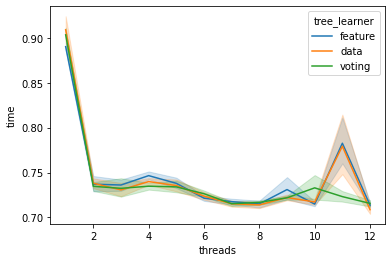

In [30]:
import seaborn as sns
sns.lineplot(data=pd.DataFrame(times), x='threads', y='time', hue='tree_learner')

In [6]:
df_times = pd.DataFrame(times)
df_times['hardware'] = 'AMD Ryzen 5 3600 6-Core Processor OC'

In [7]:
df_times.to_csv('times_amd_oc.csv')

<AxesSubplot:xlabel='threads', ylabel='time'>

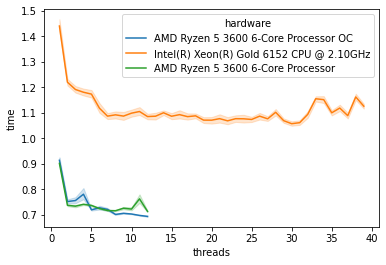

In [9]:
import seaborn as sns
sns.lineplot(data=pd.concat([df_times, pd.read_csv('times.csv', index_col=0), pd.read_csv('times_amd.csv', index_col=0)]), x='threads', y='time', hue='hardware')